<a href="https://colab.research.google.com/github/AMWBlock/AnthonyWilliams/blob/main/User_Behavior_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import io
import base64

# --- 1. Generate Sample User Log Data ---
# Create more realistic sample data
np.random.seed(42) # for reproducibility
num_logs = 1000
num_users = 100
users = [f'user_{i}' for i in range(num_users)]
pages = ['/home', '/products', '/products/item_a', '/products/item_b', '/cart', '/checkout', '/profile', '/about']
event_types = ['page_view', 'click_button', 'add_to_cart', 'purchase', 'search']

data = []
current_time = datetime(2024, 1, 1, 9, 0, 0)

# Simulate sessions and events
for _ in range(num_logs):
    user = np.random.choice(users)
    # Simulate time gaps between events (more realistic session structure)
    time_increment = timedelta(seconds=np.random.randint(1, 300)) # 1 second to 5 minutes
    current_time += time_increment

    # Simulate different event types and details
    event_type = np.random.choice(event_types, p=[0.5, 0.2, 0.1, 0.05, 0.15]) # Probabilities for each event type
    event_details = None
    if event_type == 'page_view':
        event_details = np.random.choice(pages)
    elif event_type == 'click_button':
        event_details = np.random.choice(['buy_now', 'learn_more', 'submit_form', 'login'])
    elif event_type == 'add_to_cart':
        event_details = np.random.choice(['item_a', 'item_b', 'item_c']) # Example items
    elif event_type == 'purchase':
        event_details = f'order_{np.random.randint(1000, 9999)}'
    elif event_type == 'search':
        event_details = f'query_{np.random.choice(["shoes", "shirts", "gadgets", "books"])}'

    data.append({
        'user_id': user,
        'timestamp': current_time,
        'event_type': event_type,
        'event_details': event_details
    })

df = pd.DataFrame(data)

# Convert timestamp to datetime objects
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort data for session calculation
df = df.sort_values(by=['user_id', 'timestamp']).reset_index(drop=True)

print("--- Sample Data Head ---")
print(df.head())
print("\n--- Data Info ---")
df.info()

# --- 2. Sessionization ---
# Define a session as a period of activity followed by inactivity (e.g., 30 minutes)
session_timeout = timedelta(minutes=30)

# Calculate time difference between consecutive events for each user
df['time_diff'] = df.groupby('user_id')['timestamp'].diff()

# Identify the start of a new session
# A new session starts if the time difference is greater than the timeout or if it's the user's first event
df['new_session'] = (df['time_diff'] > session_timeout) | (df['time_diff'].isna())

# Assign a unique session ID to each session
df['session_id'] = df.groupby('user_id')['new_session'].cumsum()
df['global_session_id'] = df['user_id'] + '_' + df['session_id'].astype(str)

print("\n--- Data with Session IDs ---")
print(df.head())

# --- 3. Analysis ---

# a) Popular Features/Pages (based on page_view events)
print("\n--- Popular Pages (Page Views) ---")
popular_pages = df[df['event_type'] == 'page_view']['event_details'].value_counts()
print(popular_pages)

# b) Popular Event Types
print("\n--- Popular Event Types ---")
popular_events = df['event_type'].value_counts()
print(popular_events)

# c) Session Duration Analysis
session_durations = df.groupby('global_session_id')['timestamp'].agg(['min', 'max'])
session_durations['duration'] = session_durations['max'] - session_durations['min']
session_durations['duration_seconds'] = session_durations['duration'].dt.total_seconds()

# Filter out sessions with only one event (duration 0) if desired, or keep them
# session_durations = session_durations[session_durations['duration_seconds'] > 0]

print("\n--- Session Duration Stats ---")
print(session_durations['duration_seconds'].describe())
average_session_duration = session_durations['duration_seconds'].mean()
print(f"\nAverage Session Duration: {average_session_duration:.2f} seconds")

# d) Basic User Path Analysis (Example: Page View Transitions)
# Create pairs of consecutive page views within the same session
df_pages = df[df['event_type'] == 'page_view'].copy()
df_pages['next_page'] = df_pages.groupby('global_session_id')['event_details'].shift(-1)
# Drop rows where the next page is NaN (end of session or non-page_view event followed)
page_transitions = df_pages.dropna(subset=['event_details', 'next_page'])

print("\n--- Common Page Transitions ---")
transition_counts = page_transitions.groupby(['event_details', 'next_page']).size().sort_values(ascending=False)
print(transition_counts.head(10)) # Display top 10 transitions

# e) Simple Conversion Funnel (Example: Home -> Products -> Cart -> Purchase)
print("\n--- Simple Conversion Funnel Analysis ---")
# Define funnel steps based on event types or specific page views/actions
funnel_steps = {
    'step1_view_home': df[df['event_details'] == '/home']['user_id'].nunique(),
    'step2_view_products': df[df['event_details'] == '/products']['user_id'].nunique(),
    'step3_add_to_cart': df[df['event_type'] == 'add_to_cart']['user_id'].nunique(),
    'step4_purchase': df[df['event_type'] == 'purchase']['user_id'].nunique()
}

funnel_df = pd.DataFrame(list(funnel_steps.items()), columns=['Step', 'UniqueUsers'])
funnel_df['ConversionRate'] = (funnel_df['UniqueUsers'] / funnel_df['UniqueUsers'].iloc[0]) * 100 # Rate relative to first step
funnel_df['StepConversionRate'] = (funnel_df['UniqueUsers'] / funnel_df['UniqueUsers'].shift(1).fillna(funnel_df['UniqueUsers'].iloc[0])) * 100 # Rate relative to previous step
funnel_df.loc[0, 'StepConversionRate'] = 100.0 # First step conversion is 100%

print(funnel_df)


# --- 4. Visualization ---
# Function to save plots to base64 strings for embedding
def plot_to_base64(plt):
    """Converts a matplotlib plot to a base64 encoded string."""
    img = io.BytesIO()
    plt.savefig(img, format='png', bbox_inches='tight')
    img.seek(0)
    plt.close() # Close the plot to free memory
    return base64.b64encode(img.getvalue()).decode('utf-8')

plot_data = {}

# a) Popular Pages Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x=popular_pages.values, y=popular_pages.index, palette='viridis')
plt.title('Most Popular Pages (Based on Page Views)')
plt.xlabel('Number of Views')
plt.ylabel('Page')
plot_data['popular_pages'] = plot_to_base64(plt)

# b) Session Duration Histogram
plt.figure(figsize=(10, 6))
# Use log scale if durations vary widely, or filter outliers
# For this example, filter extremely long sessions for better visualization
reasonable_durations = session_durations[session_durations['duration_seconds'] < session_durations['duration_seconds'].quantile(0.95)]['duration_seconds']
sns.histplot(reasonable_durations, bins=30, kde=True)
plt.title('Distribution of Session Durations (Seconds, 95th Percentile)')
plt.xlabel('Session Duration (seconds)')
plt.ylabel('Number of Sessions')
plot_data['session_duration_hist'] = plot_to_base64(plt)

# c) Funnel Chart (Simulated with Bar Chart)
plt.figure(figsize=(8, 5))
# Create labels with counts and conversion rates
labels = [f"{row['Step']}\n({row['UniqueUsers']} users, {row['StepConversionRate']:.1f}% step conv.)"
          for index, row in funnel_df.iterrows()]
sns.barplot(x=funnel_df['UniqueUsers'], y=labels, palette='magma')
plt.title('Conversion Funnel (Unique Users per Step)')
plt.xlabel('Number of Unique Users')
plt.ylabel('Funnel Step')
plot_data['conversion_funnel'] = plot_to_base64(plt)

# Display plots (Optional - useful in interactive environments)
# plt.show() # This would display plots locally if run outside the tool

# Print base64 strings (or you could save them to files/display in HTML)
# print("\n--- Plot Base64 Data ---")
# for name, b64_str in plot_data.items():
#    print(f"\n{name}:\ndata:image/png;base64,{b64_str[:100]}...") # Print truncated string

# --- 5. Display Results with Plots ---
print("\n\n--- Analysis Summary & Visualizations ---")
print("See the generated plots below for visual insights.")

# Generate HTML to display plots (optional, depends on execution environment)
html_output = "<h2>User Behavior Analysis Results</h2>"
html_output += "<h3>Popular Pages</h3>"
html_output += f"<img src='data:image/png;base64,{plot_data['popular_pages']}' alt='Popular Pages Bar Chart'>"
html_output += "<h3>Session Duration Distribution</h3>"
html_output += f"<img src='data:image/png;base64,{plot_data['session_duration_hist']}' alt='Session Duration Histogram'>"
html_output += "<h3>Conversion Funnel</h3>"
html_output += f"<img src='data:image/png;base64,{plot_data['conversion_funnel']}' alt='Conversion Funnel Chart'>"

# In this environment, we'll just print the summary text.
# The plots are generated and stored in plot_data if needed elsewhere.
print("\nAnalysis Complete. Summary tables printed above.")
print("Visualizations for Popular Pages, Session Durations, and Conversion Funnel have been generated.")

# If running in an environment that can render HTML:
# display(HTML(html_output)) # Requires IPython.display

--- Sample Data Head ---
  user_id           timestamp    event_type     event_details
0  user_0 2024-01-01 11:27:12     page_view             /home
1  user_0 2024-01-01 13:41:40  click_button             login
2  user_0 2024-01-01 16:11:45     page_view  /products/item_b
3  user_0 2024-01-02 03:11:56     page_view  /products/item_a
4  user_0 2024-01-02 04:31:14     page_view             /home

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   user_id        1000 non-null   object        
 1   timestamp      1000 non-null   datetime64[ns]
 2   event_type     1000 non-null   object        
 3   event_details  1000 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 31.4+ KB

--- Data with Session IDs ---
  user_id           timestamp    event_type     event_details       time_diff  \
0

<ipython-input-1-03d563bf73f6>:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=popular_pages.values, y=popular_pages.index, palette='viridis')
<ipython-input-1-03d563bf73f6>:170: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=funnel_df['UniqueUsers'], y=labels, palette='magma')




--- Analysis Summary & Visualizations ---
See the generated plots below for visual insights.

Analysis Complete. Summary tables printed above.
Visualizations for Popular Pages, Session Durations, and Conversion Funnel have been generated.




--- Analysis Summary & Visualizations ---
See the generated plots below for visual insights.



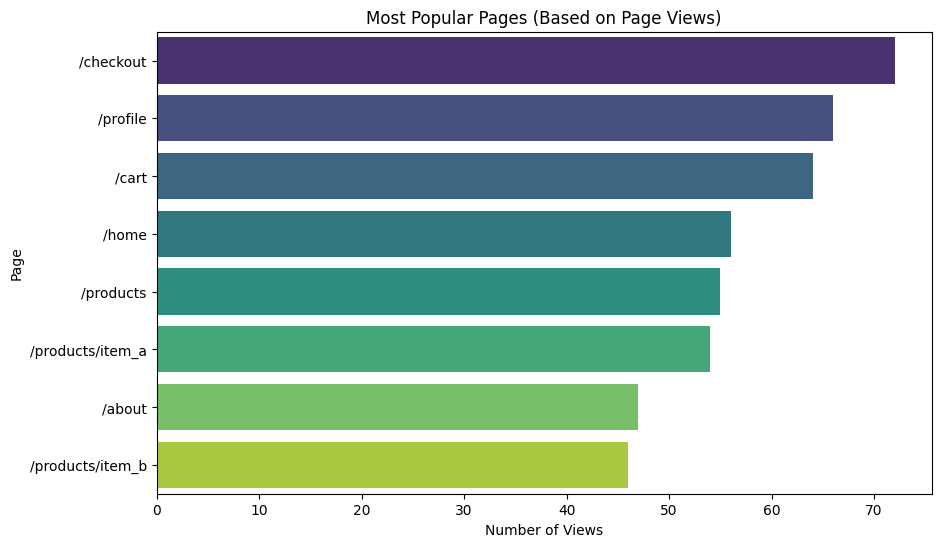
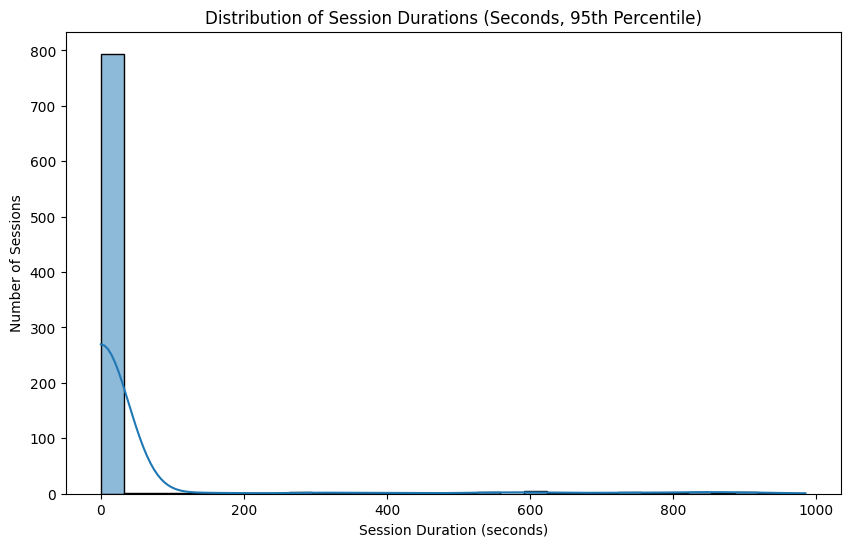
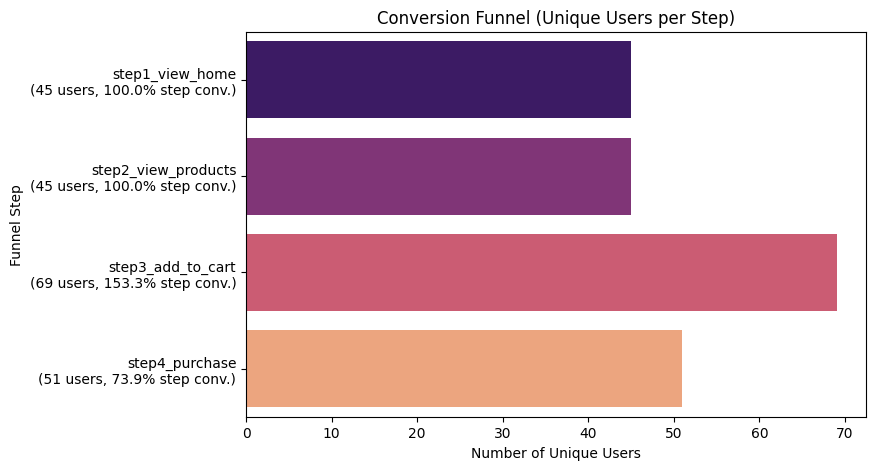


Analysis Complete. Summary tables printed above.
Visualizations for Popular Pages, Session Durations, and Conversion Funnel are displayed below.


In [2]:
# prompt: visualizations

# ... (Your existing code)

# --- 4. Visualization ---
# ... (Your existing code)


# --- 5. Display Results with Plots ---
print("\n\n--- Analysis Summary & Visualizations ---")
print("See the generated plots below for visual insights.")

# Display plots directly in the notebook using IPython.display
from IPython.display import HTML, display

# Generate HTML to display plots
html_output = "<h2>User Behavior Analysis Results</h2>"
html_output += "<h3>Popular Pages</h3>"
html_output += f"<img src='data:image/png;base64,{plot_data['popular_pages']}' alt='Popular Pages Bar Chart'>"
html_output += "<h3>Session Duration Distribution</h3>"
html_output += f"<img src='data:image/png;base64,{plot_data['session_duration_hist']}' alt='Session Duration Histogram'>"
html_output += "<h3>Conversion Funnel</h3>"
html_output += f"<img src='data:image/png;base64,{plot_data['conversion_funnel']}' alt='Conversion Funnel Chart'>"


# Display the HTML output
display(HTML(html_output))

print("\nAnalysis Complete. Summary tables printed above.")
print("Visualizations for Popular Pages, Session Durations, and Conversion Funnel are displayed below.")
